# Autoencoder using Functional API

Autoencoders are useful for identifying lower dimensional latent representations of data.  This example uses the toy Titanic dataset as a way to learn to apply an autoencoder with Tensorflow's functional API.


This architecture creates an autoencoder with 3 latent variables.

```
n_features = df_train_sc.shape[1]
encoding_dim = 3

# input placeholder
input_x = layers.Input(shape=(n_features))

encoded = layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(input_x)
encoded = layers.Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)
encoded = layers.Dense(encoding_dim, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)

decoded = layers.Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)
decoded = layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(decoded)
decoded = layers.Dense(n_features, activation='linear')(decoded)


### Create the autoencoder model. 
# This model maps an input to its reconstruction
autoencoder = models.Model(input_x, decoded)
```

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from binaryclassifier.analyzer import Analyzer
from data.utils import prepare_titanic, encode_features

THEME_COLORS = [
    '#00687F',      # Celestial Blue
    '#95C93D',      # Green
    '#58595B',      # Dark Gray
    '#00A5A3',      # Teal
    '#F2706C',      # Bright Red
    '#933B80',      # Purple
]

print('Tensorflow:', tf.__version__)

Tensorflow: 2.1.0


In [2]:
tf.__version__

'2.1.0'

In [3]:
df_train, df_test, y_train, y_test = prepare_titanic()

df_train = encode_features(df_train)
df_test = encode_features(df_test)

Download or read from disk.
Convert to pandas.DataFrame
Partition into Train and Test
    Test size = 0.3
    random_state = 123


In [4]:
class EpochDots(keras.callbacks.Callback):
    """A simple callback that prints a "." every epoch, with occasional reports.
    
    Args:
        report_every: How many epochs between full reports
        dot_every: How many epochs between dots.
    """

    def __init__(self, report_every=100, dot_every=1):
        self.report_every = report_every
        self.dot_every = dot_every

    def on_epoch_end(self, epoch, logs):
        if epoch % self.report_every == 0:
            print()
            print('Epoch: {:d}, '.format(epoch), end='')
            for name, value in sorted(logs.items()):
                print('{}:{:0.4f}'.format(name, value), end=',  ')
            print()

        if epoch % self.dot_every == 0:
            print('.', end='')

In [5]:
df_train, df_test, y_train, y_test = prepare_titanic()

# Encode columns as features
df_train = encode_features(df_train)
df_test = encode_features(df_test)

# Normalize features using training data
norm_df = df_train.describe().transpose()

def norm(x, norm_df):
    return (x - norm_df['mean']) / norm_df['std']

df_train_sc = norm(df_train, norm_df)
df_test_sc = norm(df_test, norm_df)

Download or read from disk.
Convert to pandas.DataFrame
Partition into Train and Test
    Test size = 0.3
    random_state = 123


In [6]:
METRICS = [
      keras.metrics.MeanAbsoluteError(name='mae'),
      keras.metrics.MeanSquaredError(name='mse')
]

In [7]:
# Size of encoded representation
n_features = df_train_sc.shape[1]
encoding_dim = 3

# input placeholder
input_x = layers.Input(shape=(n_features))

encoded = layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(input_x)
encoded = layers.Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)
encoded = layers.Dense(encoding_dim, activation='relu',kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)

decoded = layers.Dense(4, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(encoded)
decoded = layers.Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(decoded)
decoded = layers.Dense(n_features, activation='linear')(decoded)


### Create the autoencoder model. 
# This model maps an input to its reconstruction
autoencoder = models.Model(input_x, decoded)

### Create the encoder model.  
# This model maps an input to its encoded representation
encoder = models.Model(input_x, encoded)

###FIXME: cannot get the decoder to compile correctly.  This is less important since the decoder is not usually necessary.
### Create the decoder model. 
# This model maps encoded representation to reconstructions
#encoded_input = layers.Input(shape=encoding_dim)
# retrieve the last layer of the autoencoder model
#decoder_layer = decoder.layers[-1]
# create the decoder
#decoder = models.Model(encoded_input, decoded)

In [8]:
autoencoder.compile(optimizer='adam', 
                    loss='mse', 
                    metrics=METRICS)

history = autoencoder.fit(df_train_sc, df_train_sc,
                epochs=1000,
                batch_size=32,
                shuffle=True,
                verbose=0,
                validation_data=(df_test_sc, df_test_sc),
                callbacks=[EpochDots(report_every=100, dot_every=10)]
)


Epoch: 0, loss:0.9947,  mae:0.6874,  mse:0.9921,  val_loss:1.0979,  val_mae:0.6861,  val_mse:1.0953,  
..........
Epoch: 100, loss:0.4031,  mae:0.3711,  mse:0.3989,  val_loss:0.5483,  val_mae:0.3889,  val_mse:0.5441,  
..........
Epoch: 200, loss:0.3488,  mae:0.3225,  mse:0.3437,  val_loss:0.4730,  val_mae:0.3351,  val_mse:0.4679,  
..........
Epoch: 300, loss:0.3247,  mae:0.3055,  mse:0.3191,  val_loss:0.4335,  val_mae:0.3168,  val_mse:0.4280,  
..........
Epoch: 400, loss:0.3035,  mae:0.3065,  mse:0.2978,  val_loss:0.3731,  val_mae:0.3176,  val_mse:0.3674,  
..........
Epoch: 500, loss:0.2959,  mae:0.3199,  mse:0.2904,  val_loss:0.3381,  val_mae:0.3268,  val_mse:0.3326,  
..........
Epoch: 600, loss:0.2748,  mae:0.3196,  mse:0.2697,  val_loss:0.2734,  val_mae:0.3201,  val_mse:0.2683,  
..........
Epoch: 700, loss:0.2568,  mae:0.3082,  mse:0.2518,  val_loss:0.2511,  val_mae:0.3099,  val_mse:0.2461,  
..........
Epoch: 800, loss:0.2483,  mae:0.3016,  mse:0.2434,  val_loss:0.2403,  val

Plotting the learning curve shows that the model is converging after around 800 epochs. It may still need some tuning since the validation set unexpectedly converges below the training set.

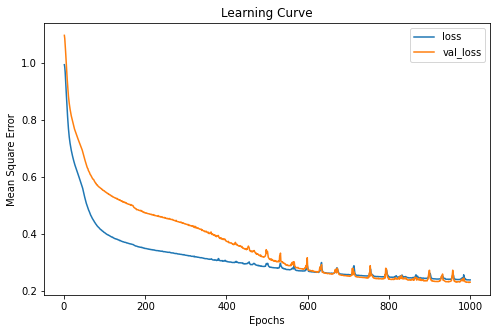

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist['epoch'] = hist['epoch'] + 1

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(hist['epoch'], hist['loss'], label='loss')
ax.plot(hist['epoch'], hist['val_loss'], label='val_loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.legend()
plt.show()

Calling predict on the encoder model returns the latent features.

In [13]:
encoder.predict(df_train_sc)

array([[ 4.5122237 ,  0.        ,  5.1646957 ],
       [ 0.        ,  7.473511  ,  5.4687333 ],
       [ 0.29151893,  1.9523813 ,  3.3893952 ],
       ...,
       [ 1.9410379 ,  0.        ,  0.44714108],
       [ 0.        ,  8.731602  ,  8.032708  ],
       [18.195528  ,  0.        , 13.835117  ]], dtype=float32)

Since the latent variables have relu activations, they range from 0 to +inf.

In [19]:
pd.DataFrame(encoder.predict(df_train_sc)).describe()

,0,1,2
count,916.000000,916.000000,916.000000
mean,2.171626,1.706545,3.506188
std,2.916344,3.151037,4.459629
min,0.000000,0.000000,0.000000
25%,0.285134,0.000000,1.251384
50%,1.923835,0.000000,2.223986
75%,2.706581,2.122719,5.244450
max,18.349312,50.940140,103.672447


The latent variables generally have low correlation with each other since they carry different information.

In [20]:
pd.DataFrame(encoder.predict(df_train_sc)).corr()

,0,1,2
0,1.000000,-0.379574,0.212222
1,-0.379574,1.000000,0.688631
2,0.212222,0.688631,1.000000


Calling predict on the autoencoder model returns the reconstructed features.

In [22]:
df_test_rec = pd.DataFrame(autoencoder.predict(df_test_sc), columns=df_test_sc.columns)
df_test_rec.head()

,age,cabin,fare,sex,pclass,sibsp,ticket,embarked_0,embarked_1,embarked_2,embarked_3
0,0.185554,0.185381,-0.429324,-0.283735,0.083654,-0.547557,-0.190209,-0.532743,-0.339177,0.686026,-0.034217
1,0.687350,-0.838047,0.235801,-0.049409,-0.883654,-0.664766,-0.237208,-0.693424,0.254210,0.473551,-0.155150
2,0.342278,0.001247,-0.360191,-0.312105,-0.110510,-0.742800,-0.178083,-0.556720,-0.337512,0.710643,-0.057131
3,-0.074435,0.648563,-0.720114,-0.389273,0.592739,-0.459926,0.256022,-0.465227,-0.334001,0.609998,0.033958
4,-0.415660,0.685161,-0.369386,0.021360,0.696571,0.844334,0.180476,-0.512359,-0.328362,0.642702,-0.012195


We can check the Pearson correlation coefficient for the feature and its reconstruction.  All variables have a positive correlation like we want, some appear quite high.  The highest ones appear to be the indicator or category variables.

In [28]:
for feature in df_test_sc.columns:
    corr = np.corrcoef(df_test_rec[feature], df_test_sc[feature])[0,1]
    print(feature.ljust(12), str(round(corr, 3)))
    

age          0.562
cabin        0.862
fare         0.795
sex          0.437
pclass       0.918
sibsp        0.912
ticket       0.98
embarked_0   0.992
embarked_1   0.992
embarked_2   0.993
embarked_3   0.997
